# Generate artificial networks with a preset redundancy and synergy. 

In [1]:
from functions import *

Generate a large number of TSE values for extreme R and S distributions to observe behaviour

In [8]:
TSE_R = []
TSE_S = []
TSE_0 = []

for i in range(10000):
    R_sum = 100
    S_sum = 0
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_R.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 0
    S_sum = 100
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_S.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 50
    S_sum = 50
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_0.append(compute_tse_complexity(Ninfomut_artificial))

In [9]:
# Remove extreme values
TSE_R_filtered = remove_extremes(TSE_R)
TSE_S_filtered = remove_extremes(TSE_S)
TSE_0_filtered = remove_extremes(TSE_0)

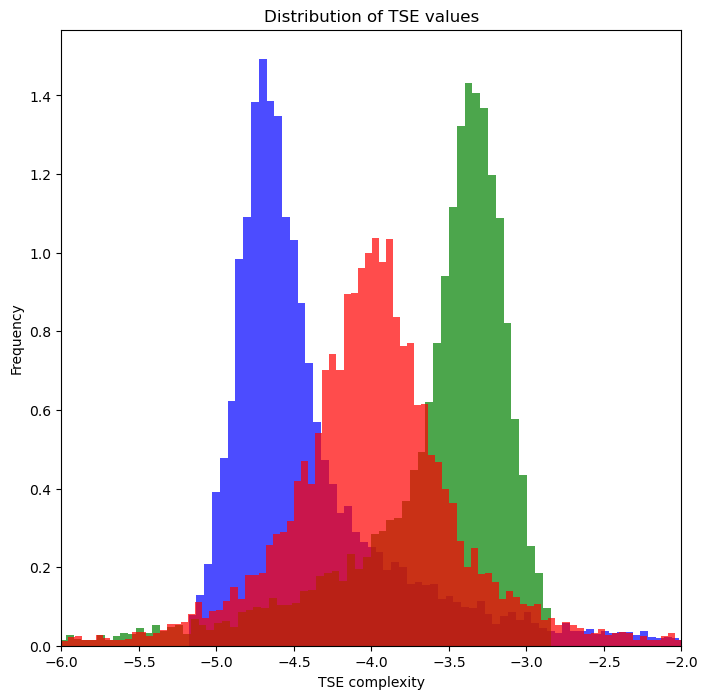

In [10]:
# Plot histograms for the three lists
plt.hist(TSE_R_filtered, bins=100, color='blue', alpha=0.7, label='R dominated networks', density=True)
plt.hist(TSE_S_filtered, bins=100, color='green', alpha=0.7, label='S dominated networks', density=True)
plt.hist(TSE_0_filtered, bins=100, color='red', alpha=0.7, label='Equal S and R', density=True)
plt.xlim(-6, -2)

# IF USEFUL FOR VISUALISATION # Rescale x-axis to make -4 correspond to 0
#ticks = plt.xticks()[0]  # Get current tick positions
#rescaled_ticks = ticks + 4  # Shift ticks by 4
#plt.xticks(ticks, [f"{t}" for t in rescaled_ticks])  # Update tick labels

# Add title and labels
plt.title('Distribution of TSE values')
plt.xlabel('TSE complexity')
plt.ylabel('Frequency')

# Add legend to distinguish the lists
#plt.legend()

# Show the plot
plt.show()

Use functions to generate TSE values for a range of R and S values 

In [11]:
# Main script
nb_of_variables = 10
simulations_per_S_R_balance = 10000
max_R_S_value = 10000
nb_of_R_S_values = 20

# Create empty DataFrame with appropriate row/column labels
stepsize = max_R_S_value / nb_of_R_S_values
max_MI_value = int(max_R_S_value + stepsize)
rows = [f"{i}" for i in np.arange(0, max_MI_value, int(stepsize))]
columns = [f"{j}" for j in np.arange(0, max_MI_value, int(stepsize))]
TSE_df = pd.DataFrame(index=rows, columns=columns)

# Fill the DataFrame in parallel
TSE_df = fill_TSE_df(TSE_df, nb_of_variables, simulations_per_S_R_balance)

Plot the TSE values in a heatmap to visualise the dependence on redundancy and synergy

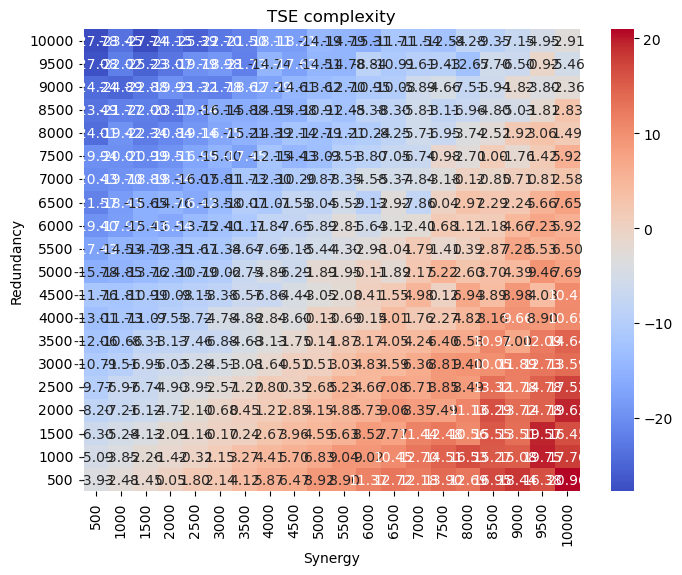

In [12]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add title and labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()

Plot the TSE values without printing the values to optimise visibility.

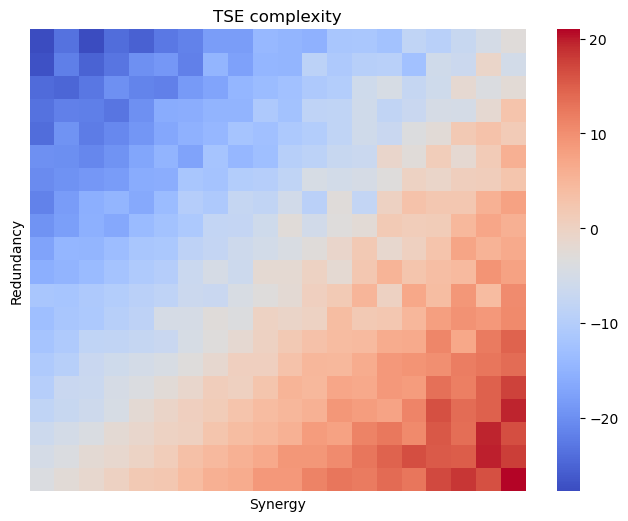

In [13]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap without annotations
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Hide the axis ticks but keep the labels
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks

# Add title with axis labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()